**Face Mask Detection(Used MobileNet model)**

In [126]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [127]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [128]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [129]:
!ls


 deploy.prototxt			    sample_data
 face-mask-12k-images-dataset.zip	    testingModel
'Face Mask Dataset'			    wm2.jpg
 kaggle.json				    wm3.jpg
 res10_300x300_ssd_iter_140000.caffemodel   wom2.jpg


In [130]:
from zipfile import ZipFile
file_name = "face-mask-12k-images-dataset.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")


Done


In [6]:
!ls "Face Mask Dataset"/Test


WithMask  WithoutMask


In [131]:
training_dir = "Face Mask Dataset/Test"
valid_dir = "Face Mask Dataset/Validation/"
test_dir  = "Face Mask Dataset/Test/"

In [132]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from imutils.video import VideoStream
import time
import imutils
import os

grab the list of images in our dataset directory, then initialize
the list of data (i.e., images) and class images

In [133]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

imagePaths = list(paths.list_images(training_dir))
data = []
labels = []

PreProcessing


In [134]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

convert the data and labels to NumPy arrays

In [135]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

perform one-hot encoding on the labels

In [136]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

construct the training image generator for data augmentation
And Loading the MobileNet model

In [137]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [138]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False


compile our model

In [139]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

train the head of the network

In [ ]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

make predictions on the testing set

In [141]:
predIdxs = model.predict(testX, batch_size=BS)

Saving the model

In [ ]:
model.save("testingModel", save_format="h5")

plot the training loss and accuracy

Visualization

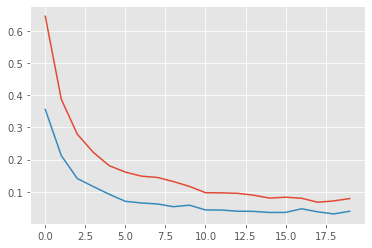

In [142]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

Switching to Regular Jupyter Notebook